In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from math import floor, ceil
from pylab import rcParams

%matplotlib inline

In [2]:
sns.set(style='ticks', palette='Spectral', font_scale=1.5)

material_palette = ["#4CAF50", "#2196F3", "#9E9E9E", "#FF9800", "#607D8B", "#9C27B0"]
sns.set_palette(material_palette)
rcParams['figure.figsize'] = 16, 8

plt.xkcd();
random_state = 42
np.random.seed(random_state)
tf.set_random_seed(random_state)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
clustering_df = pd.read_csv("Config5.txt", sep=",")


           Event  ChanWidth     Type    NHits    SumADC  TimeWidth      ENu
count   1163.000   1163.000 1163.000 1163.000  1163.000   1163.000 1163.000
mean  312153.655      6.061    0.999    9.213  2099.755     29.908   21.298
std   249586.301      3.237    0.029    3.296  1462.227     19.323    6.337
min    94003.000      1.000    0.000    6.000   465.897      1.031    8.456
25%    94582.500      4.000    1.000    7.000  1169.695     15.968   16.758
50%   189381.000      5.000    1.000    8.000  1723.470     25.509   20.298
75%   502507.500      8.000    1.000   11.000  2539.380     39.218   24.832
max   844598.000     24.000    1.000   27.000 14707.900    155.987   55.707


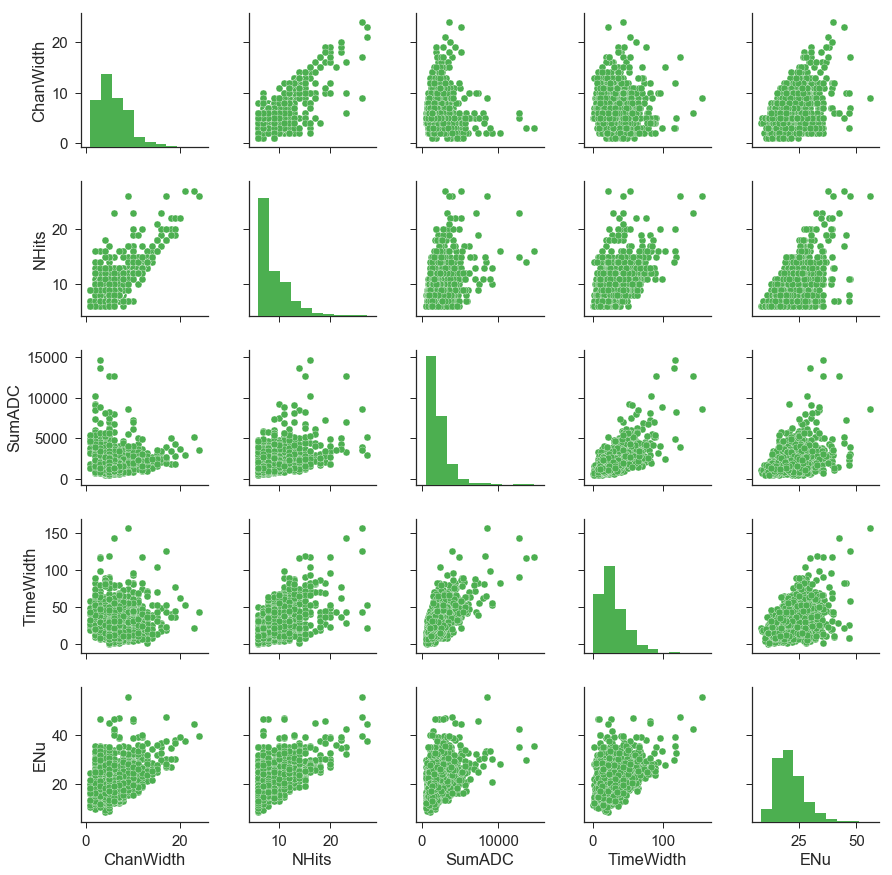

In [3]:
print(clustering_df.describe())
sns.pairplot(clustering_df[['ChanWidth', 'NHits', 'SumADC', 'TimeWidth', 'ENu']]);

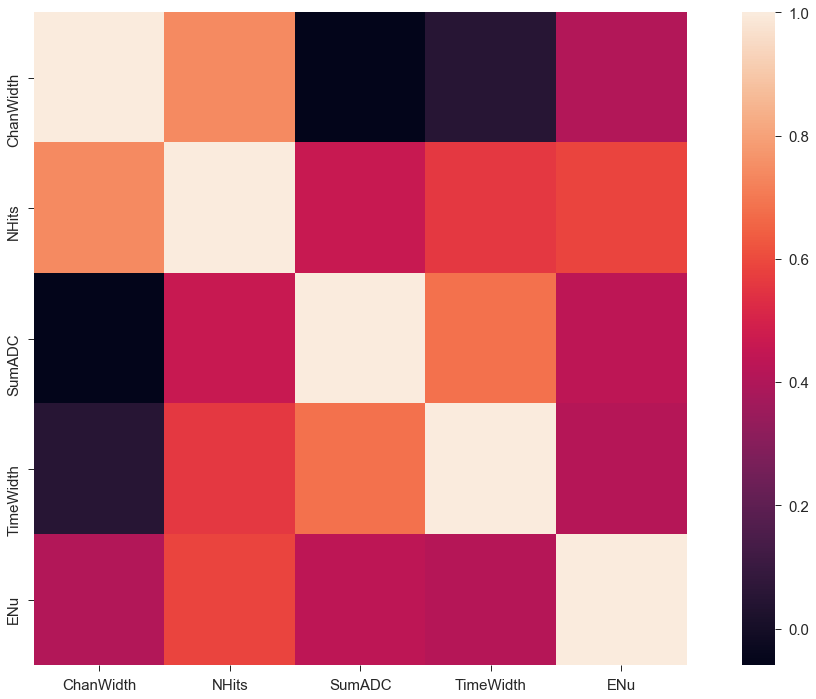

In [4]:
corr_mat = clustering_df[['ChanWidth', 'NHits', 'SumADC', 'TimeWidth', 'ENu']].corr() 
fig, ax = plt.subplots(figsize=(20, 12)) 
sns.heatmap(corr_mat, vmax=1.0, square=True, ax=ax);

In [5]:
def encode(series): 
  return pd.get_dummies(series.astype(str))

In [6]:
train_x=pd.DataFrame()
train_y=pd.DataFrame()
print(type(np.float32(clustering_df.ChanWidth)))
print((np.float32(clustering_df.ChanWidth)).shape)
train_x['ChanWidth'] = np.float32(clustering_df.ChanWidth)
train_x['NHits'] = np.float32(clustering_df.NHits)
train_x['SumADC'] = np.float32(clustering_df.SumADC)
train_x['TimeWidth'] = np.float32(clustering_df.TimeWidth)
train_x = pd.concat([train_x], axis=1)
train_y['ENu'] = np.float32(clustering_df.ENu)
print(type(train_x))

<class 'numpy.ndarray'>
(1163,)
<class 'pandas.core.frame.DataFrame'>


In [7]:
train_size = 0.9
train_cnt = floor(train_x.shape[0] * train_size)
x_train = train_x.iloc[0:train_cnt].values
y_train = train_y.iloc[0:train_cnt].values
x_test = train_x.iloc[train_cnt:].values
y_test = train_y.iloc[train_cnt:].values

In [8]:
def multilayer_perceptron(x, weights, biases):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return out_layer

In [9]:
n_hidden_1 = 10
n_input = train_x.shape[1]
print(n_input)
n_classes = 1

weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_hidden_1, n_classes]))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

keep_prob = tf.placeholder("float")

4


In [10]:
training_epochs = 2
cost_arr=np.zeros(training_epochs)
display_step = 100
batch_size = 32

x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

In [11]:
predictions_nn = multilayer_perceptron(x, weights, biases)
cost = tf.reduce_mean(tf.losses.mean_squared_error(predictions=predictions_nn, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

Epoch: 0000 cost= 19482712.000000000
Optimization Finished!
(1046, 1)
(1046, 1)


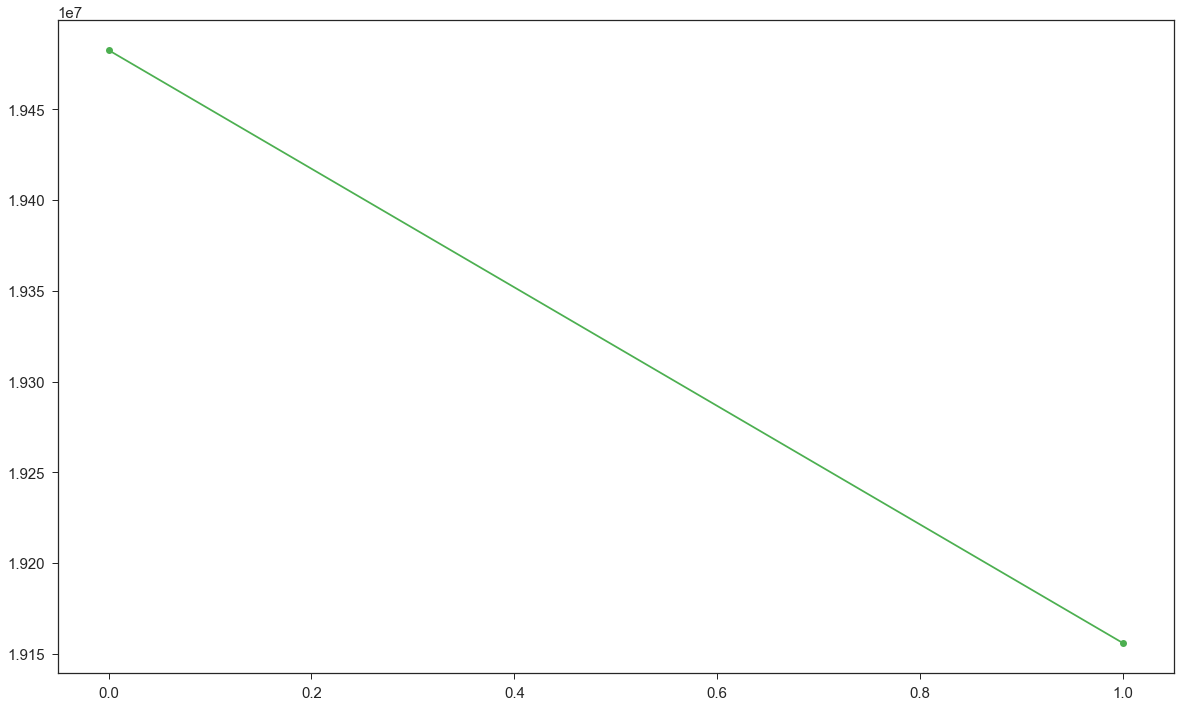

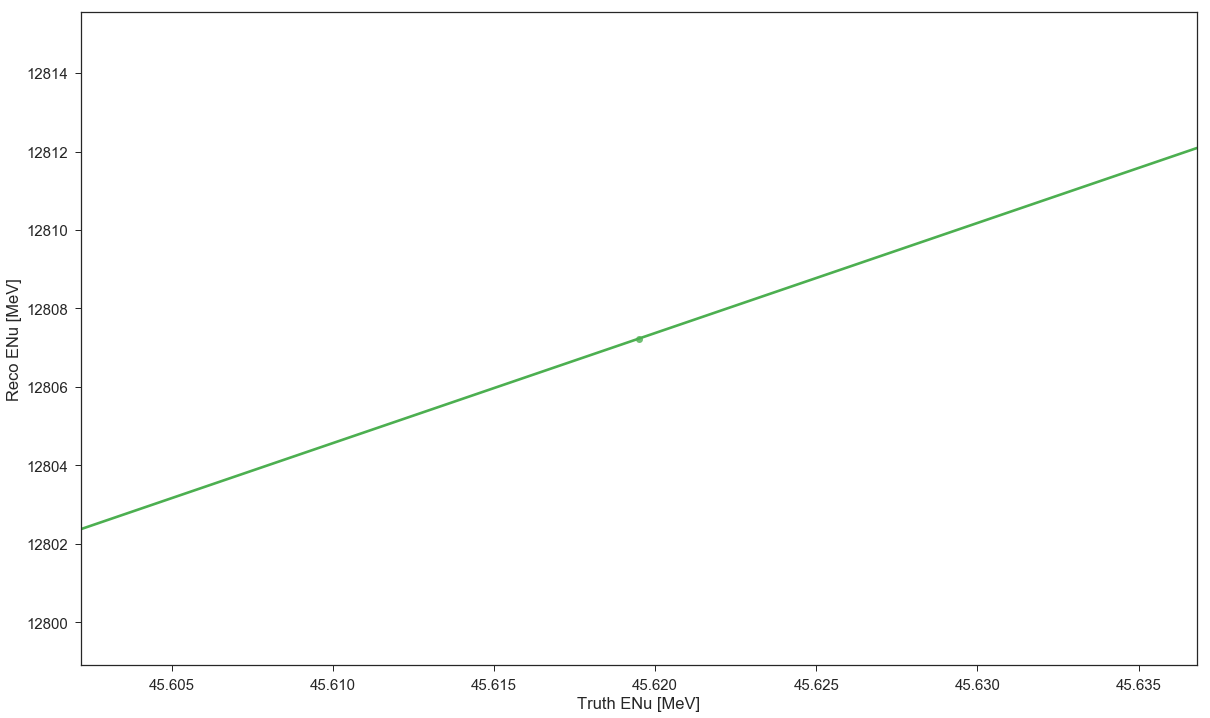

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(training_epochs):
        avg_cost = 0.0
        total_batch = 1#int(len(x_train) / batch_size)
        #x_batches = np.array_split(x_train, total_batch)
        #y_batches = np.array_split(y_train, total_batch)
        x_batch = x_train
        y_batch = y_train
        #for i in range(total_batch):
        #batch_x, batch_y = x_batches[i], y_batches[i]
        _, c, pred = sess.run([optimizer, cost, predictions_nn], feed_dict={x: x_batch, y: y_batch})
        multilayer_perceptron(x_batch, weights, biases)
        cost_arr[epoch]=c
        avg_cost += c / total_batch
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch), "cost=", "{:.9f}".format(avg_cost))
    print("Optimization Finished!")
    
    
    fig, ax = plt.subplots(figsize=(20, 12))
    plt.plot(range(cost_arr.shape[0]),cost_arr, 'o-')
    fig, ax = plt.subplots(figsize=(20, 12))
    #plt.plot(y_train,pred, 'o')
    final_df=pd.DataFrame()
    print(pred.shape)
    print(y_train.shape)
    final_df['Truth ENu [MeV]']=np.float32(y_train[:][0])
    final_df['Reco ENu [MeV]']=np.float32(pred[:][0])
    sns.regplot(x="Truth ENu [MeV]",y="Reco ENu [MeV]",data=final_df)